In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Iat is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from PIL import Image
import os

In [ ]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work

print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])


print ('Available devices ', torch.cuda.device_count())



__Python VERSION: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
__pyTorch VERSION: 1.8.1+cu101
__CUDA VERSION
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Available devices  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.optim import SGD

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driveFiles = GoogleDrive(gauth)

In [ ]:
from pathlib import Path
base = Path('/content/drive/MyDrive/computer-vision/')
sys.path.append(str(base))
zippath= base/'Data_train.zip'
!cp "{zippath}" .
!unzip -q Data_train.zip
!rm Data_train.zip

In [ ]:
zippath= base/'Data_test.zip'
!cp "{zippath}" .
!unzip -q Data_test.zip
!rm Data_test.zip



In [ ]:
zippath= base/'Data_valid.zip'
!cp "{zippath}" .
!unzip -q Data_valid.zip
!rm Data_valid.zip


In [ ]:
data_transforms_train = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transforms_valid = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transforms_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
#Load the datasets with ImageFolder
datadir='/content/'
train_dir=datadir + 'Data_train'
valid_dir=datadir + 'Data_valid'
test_dir=datadir + 'Data_test'
image_dataset_train = datasets.ImageFolder(train_dir, transform = data_transforms_train)
image_dataset_valid = datasets.ImageFolder(valid_dir, transform = data_transforms_valid)
image_dataset_test = datasets.ImageFolder(test_dir, transform = data_transforms_test)

In [ ]:
# Using the image datasets and the trainforms, define the dataloaders
#batch size and num workers can be modified accordingly. 
batch_size =64
num_workers=2
 

dataloader_train = torch.utils.data.DataLoader(image_dataset_train, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(image_dataset_valid, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)

dataloader_test = torch.utils.data.DataLoader(image_dataset_test, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)

In [ ]:
#Define classnames
class_names = image_dataset_train.classes

In [ ]:
class_names

['a', 'c', 'd', 'g', 'h', 'm', 'n', 'o']

In [ ]:
starts=class_names
label=[1,2,3,4,5,6,7,8]
dict_=dict(zip(starts,label))

In [ ]:
#Train on multiple GPUs if available, else train on cpu
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Mon May 24 15:36:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class Optimizer():
    # is used to get rid of code inside the training loop
    def __init__(self, parameters, lr=0.4):
        self.parameters, self.lr = list(parameters), lr

    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.parameters:
            p.grad.zero_()

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def flatten(x):
    return x.view(x.shape[0], -1)

# we can also use that Lambda class to resize the data as in the above cell
def resize(x): return x.view(-1, 3, 224, 224) 

In [ ]:

EPOCHS = 6
lr = 0.4

loss_func = F.cross_entropy
class cnn_lamyae(nn.Module):
  def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
                Lambda(resize),
                nn.Conv2d(in_channels=3, out_channels=64,
                    kernel_size=3, stride=1, padding=1),  # bs*64*224*224
                nn.ReLU(),
                #nn.Conv2d(in_channels=64, out_channels=64,
                #kernel_size=3, stride=1, padding=1),  # bs*64*224*224
                #nn.ReLU(),
                nn.MaxPool2d((2,2),stride=(2,2)),  #bs*64*112*112
                nn.Conv2d(64, 128, 3, 1, 1),  # bs*128*112*112
                nn.ReLU(),
                #nn.Conv2d(128, 128, 3, 1, 1),  # bs*128*112*112
                #nn.ReLU(),
                nn.MaxPool2d((2,2),stride=(2,2)),  #bs*128*56*56,
                nn.Conv2d(128, 256, 3, 1, 1),  # bs * 256 * 56 * 56
                nn.ReLU(),
                #nn.Conv2d(256, 256, 3, 1, 1),  # bs * 256 * 56 * 56
                #nn.ReLU(),
                nn.MaxPool2d((2,2),stride=(2,2)),  #bs*256*28*28,
                nn.Conv2d(256, 512, 3, 1, 1),  # bs * 512 * 28 * 28
                nn.ReLU(),
                #nn.Conv2d(512, 512, 3, 1, 1),  # bs * 512 * 28 * 28
                #nn.ReLU(),
                #nn.Conv2d(512, 512, 3, 1, 1),  # bs * 512 * 28 * 28
                #nn.ReLU(),
                nn.MaxPool2d((2,2),stride=(2,2)),  #bs*512*14*14,
                nn.Conv2d(512, 512, 3, 1, 1),  # bs * 512 * 14 * 14
                nn.ReLU(),
                #nn.Conv2d(512, 512, 3, 1, 1),  # bs * 512 * 28 * 28
                #nn.ReLU(),
                #nn.Conv2d(512, 512, 3, 1, 1),  # bs * 512 * 28 * 28
                #nn.ReLU(),
                nn.MaxPool2d((2,2),stride=(2,2)))  #bs*512*7*7,

        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(4096, 8))
  def forward(self, x):
     x = self.features(x)
     h = x.view(x.shape[0], -1)
     x = self.classifier(h)
     return x, h



In [ ]:
OUTPUT_DIM = 8

model = cnn_lamyae(OUTPUT_DIM)

In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [ ]:
model.apply(initialize_parameters)

cnn_lamyae(
  (features): Sequential(
    (0): Lambda()
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18):

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), '/content/drive/MyDrive/computer-vision/init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('/content/drive/MyDrive/computer-vision/init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(dataloader_train, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 2):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

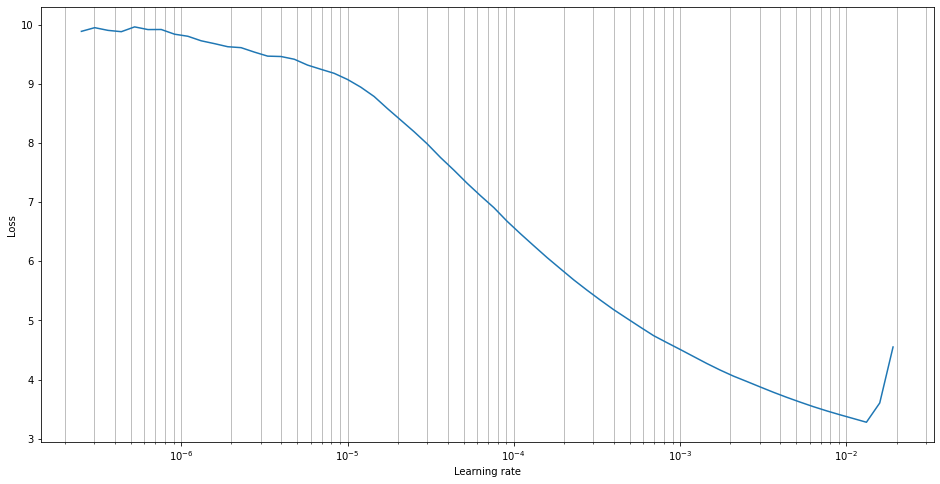

In [ ]:
plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [ ]:
from torchsummary import summary

In [ ]:
summary(learner, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Lambda-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
              ReLU-5         [-1, 64, 224, 224]               0
         MaxPool2d-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

In [ ]:
def accuracy(output,target):
  return (torch.argmax(output,dim=1)== target).float().mean()

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 25
import time
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, dataloader_train, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, dataloader_valid, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/tut3-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 56s
	Train Loss: 2.107 | Train Acc: 12.56%
	 Val. Loss: 2.084 |  Val. Acc: 11.46%
Epoch: 02 | Epoch Time: 0m 56s
	Train Loss: 2.104 | Train Acc: 12.90%
	 Val. Loss: 2.079 |  Val. Acc: 14.08%
Epoch: 03 | Epoch Time: 0m 55s
	Train Loss: 2.107 | Train Acc: 12.35%
	 Val. Loss: 2.082 |  Val. Acc: 11.70%
Epoch: 04 | Epoch Time: 0m 56s
	Train Loss: 2.077 | Train Acc: 12.78%
	 Val. Loss: 2.058 |  Val. Acc: 16.93%
Epoch: 05 | Epoch Time: 0m 58s
	Train Loss: 2.061 | Train Acc: 16.03%
	 Val. Loss: 1.992 |  Val. Acc: 21.92%
Epoch: 06 | Epoch Time: 0m 56s
	Train Loss: 1.891 | Train Acc: 27.52%
	 Val. Loss: 1.759 |  Val. Acc: 37.52%
Epoch: 07 | Epoch Time: 0m 56s
	Train Loss: 1.616 | Train Acc: 39.44%
	 Val. Loss: 1.501 |  Val. Acc: 46.46%
Epoch: 08 | Epoch Time: 0m 56s
	Train Loss: 1.343 | Train Acc: 47.00%
	 Val. Loss: 1.266 |  Val. Acc: 50.41%
Epoch: 09 | Epoch Time: 0m 56s
	Train Loss: 1.184 | Train Acc: 52.26%
	 Val. Loss: 1.176 |  Val. Acc: 55.62%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('/content/tut3-model.pt'))

test_loss, test_acc = evaluate(model, dataloader_test, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.788 | Test Acc: 44.09%


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, dataloader_test, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon May 24 10:41:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |  15951MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------